# Importação de pacotes

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.classification import *
from imblearn.under_sampling import ClusterCentroids
from pycaret.utils import check_metric
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [184]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.2.


# Carregando os dados

In [185]:
# carregando os dados para o formato DataFrame
data = pd.read_csv("fetal_health.csv", sep=",")

# imprimindo as 5 primeiras linhas
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


# Preparação dos dados

Foi necessário um mapeamento da variável alvo para evitar um erro no momento da predição usando os dados de teste. Abaixo está a referência usada para corrigir o problema.

>@moezali1 thanks for your reply. I have found theissue if the target label starts with 1, it will hit this error. For example if I use 1,2,3 to label 3 types of Iris, it hit the error, but if I change it to 0,1,2 it work.

[[BUG]: Predict model index out of bound for multi class](https://github.com/pycaret/pycaret/issues/2494)

In [186]:
# imprimindo valores únicos
print(data.fetal_health.unique())

[2. 1. 3.]


In [187]:
# mapeando a variável alvo
# valor 1 será 0
# valor 2 será 1
# valor 3 será 2
data.fetal_health = data.fetal_health.map({1.0: 0, 2.0: 1, 3.0: 2})

# imprimindo valores unicos
data.fetal_health.unique()

array([1, 0, 2], dtype=int64)

# Separando dados em treino e teste

A função `sample()` do Pandas DataFrame é usada para obter uma amostra aleatória de linhas ou colunas de um DataFrame. A função retorna um novo DataFrame que contém uma fração aleatória de linhas ou colunas do DataFrame original.

O parâmetro frac determina a fração de linhas que você deseja retornar em vez de um número fixo. Neste caso é usado somente 10% do dados para formar o conjunto de teste e 90% para formar os nossos dados de treino.

In [188]:
# separando os dados em teste e treino
test = data.sample(frac=0.10)
train = data.drop(test.index)

# redefinindo o index do DataFrame descartando o indice anterior (drop=True) e realizando a alteração no próprio DataFrame (inplace=True) 
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)

In [189]:
# verificando o formato dos conjuntos
print(f"Shape do conjunto de treino {train.shape}")
print(f"Shape do conjunto de teste {test.shape}")

Shape do conjunto de treino (1913, 22)
Shape do conjunto de teste (213, 22)


# Setup dos modelos

O método `setup()` do PyCaret é usado para preparar os dados para modelagem de aprendizado de máquina. Ele executa várias etapas de pré-processamento de dados, como:

* Separar o conjunto de dados em treinamento e teste.
* Lidar com valores ausentes e valores discrepantes (outliers).
* Codificar variáveis categóricas.
* Normalizar ou padronizar variáveis numéricas.
* Selecionar recursos (features) importantes.
* Balancear os dados.

O método `setup()` retorna um objeto contendo várias informações sobre o pré-processamento de dados que foi realizado, bem como uma pré-visualização dos dados transformados. A partir desse objeto, você pode criar, treinar e avaliar modelos de aprendizado de máquina usando o PyCaret.

Para o balanceamento dos dados é necessário informar ao método `setup()` qual algoritmo deverá ser usado para fazer este balanceamento. Neste projeto será utilizado o algoritmo ClusterCentroids que submete as amostras substituindo um cluster das classes majoritárias pelo seus centroides de um algoritmo K-Means. O algoritmo é repetido n vezes até que todas as classes tenham o mesmo número de exemplos da classe minoritária.

In [190]:
# instanciando objeto utilizando a estratégia de manter a classe minoritária
cc = ClusterCentroids(sampling_strategy="not minority", random_state=42)

## IMPORTANTE

O balanceamento dos dados somente é aplicado durante o processo de treinamento e por fold, para remover o risco de vazamento de dados. Pontanto, qualquer alteração feita pelos algoritmos de balanceamento de dados como SMOTE ou ClusterCentroids, não são visíveis nos dataframes obtifos pelo método `get_config`.

In [191]:
# criando o setup do PyCaret
models = setup(data=train,
               target="fetal_health",
               train_size=0.7,
               preprocess=True,
               normalize=True,
               fix_imbalance = True,
               fix_imbalance_method = cc,
               fold_strategy="kfold",
               fold=5,
               session_id=123, 
               experiment_name='fetal_health_experiment')

,Description,Value
0,session_id,123
1,Target,fetal_health
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(1913, 22)"
5,Missing Values,False
6,Numeric Features,20
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


# Comparando os modelos

O método `compare_models` do PyCaret é usado para comparar o desempenho de vários modelos de aprendizado de máquina em um conjunto de dados, usando o método de validação cruzada e as princiáis métricas para avaliação em modelos de regressão.

Ao chamar o método `compare_models`, o PyCaret executa automaticamente um experimento de modelagem de aprendizado de máquina usando vários algoritmos de modelagem diferentes. Ele usa um método de validação cruzada para treinar e avaliar cada modelo, dividindo o conjunto de dados em vários subconjuntos e avaliando o desempenho do modelo em cada subconjunto.

O resultado do `compare_models` é uma tabela de classificação de desempenho dos modelos, ordenados pela métrica de avaliação escolhida.

O método `compare_models` nos retorna o modelo que melhor performou, já treinado, entre todos os testados usando como indicador a métrica `AUC`.

Neste caso, o modelo vencedor foi o **Extra Trees Classifier** com um **AUC** de **0.9627**.

In [192]:
best = compare_models(sort='auc')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8320,0.9600,0.8537,0.8965,0.8493,0.6245,0.6558,0.2220
lr,Logistic Regression,0.8327,0.9525,0.8235,0.8870,0.8485,0.6180,0.6419,1.3800
rf,Random Forest Classifier,0.7722,0.9462,0.8404,0.8792,0.7977,0.5347,0.5858,0.2160
lda,Linear Discriminant Analysis,0.7924,0.9459,0.8131,0.8802,0.8160,0.5565,0.5963,0.1520
gbc,Gradient Boosting Classifier,0.7244,0.9381,0.8387,0.8732,0.7557,0.4734,0.5455,0.2260
knn,K Neighbors Classifier,0.8223,0.9359,0.8107,0.8832,0.8398,0.5944,0.6214,0.6220
nb,Naive Bayes,0.6625,0.9243,0.7039,0.8644,0.7041,0.3901,0.4681,0.5120
lightgbm,Light Gradient Boosting Machine,0.6713,0.9175,0.8076,0.8585,0.7058,0.4159,0.4942,0.1800
ada,Ada Boost Classifier,0.5749,0.8605,0.7257,0.8534,0.6188,0.3079,0.4089,0.1660
dt,Decision Tree Classifier,0.6550,0.7720,0.7859,0.8433,0.6881,0.3853,0.4614,0.1460


Imprimindo o modelo vencedor é possível ver seus hiperparâmetros definidos durante a execução do método ``compare_models()``.

In [193]:
print(best)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)


# Avaliando o modelo vencedor

Vale relembrar nesta etapa que nossa variável alvo é **fetal_health** ou seja, a classificação de saúde fetal.

Além disso, foi necessário alterar seus valores para corrigir um problema durante a predição, sendo assim, os novos valores são:

* Normal == 0
* Suspeito == 1
* Patológico == 2

## Matriz de confusão 

Avaliando o contexto do problema podemos dizer que os pontos abaixo devem ter um maior peso durante a avaliação da matriz de confusão.

1. Identificar classificações feitas como Normal (0) e que na verdade foram Suspeitas (1) ou Patológicas (2).
2. Identificar classificações feitas como Suspeitas (1) e que na verdade foram Patológicas (2).

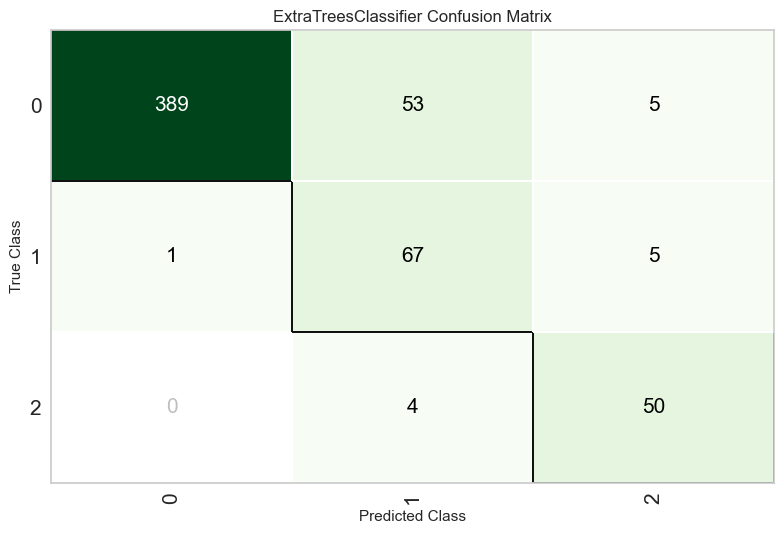

In [194]:
# plotando matriz de confusão
plot_model(best, plot='confusion_matrix')

1. O modelo errou em somente 1 previsão classificando a saúde fetal como Normal (0) onde o correto é Suspeito (1)
2. O modelo errou em somente 4 previsões classificando a saúde fetal como Suspeita (1) onde o correto é Patológico (2)

Tivemos ainda 53 classificações onde o modelo classificou como Suspeita (1) onde na verdade é Normal (0), porém, este erro é menos relevante neste contexto e não causaria grandes impactos negativos.

## Curva de precisão e recall

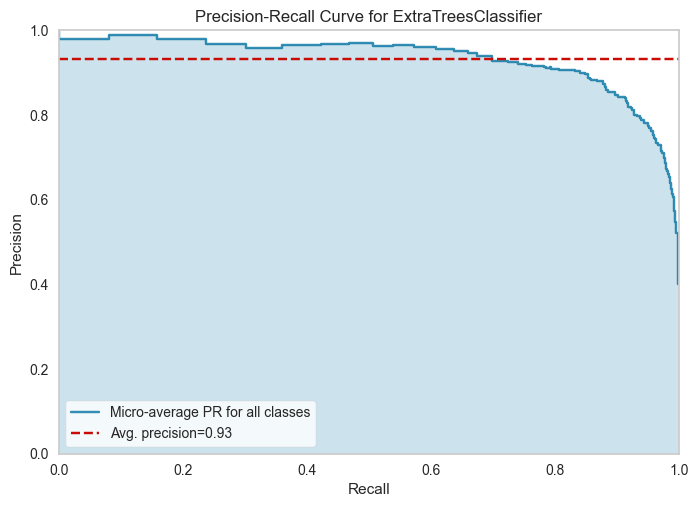

In [195]:
# plotando curva de precisão em recall
plot_model(best, plot='pr')

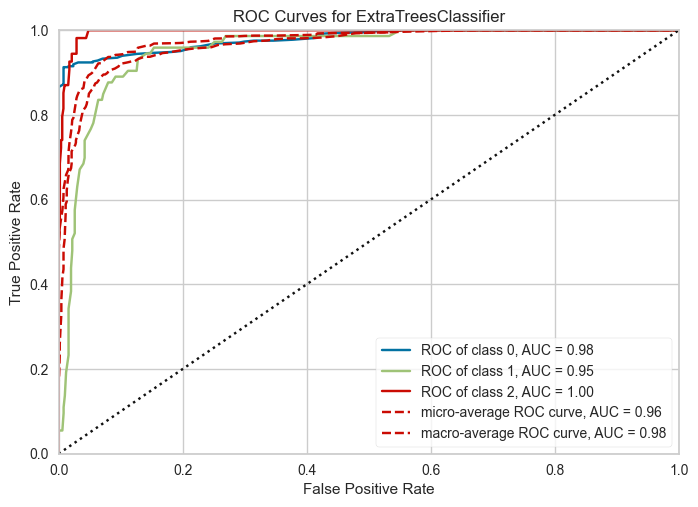

In [196]:
# plotando auc
plot_model(best, plot='auc')

Obtivemos um AUC muito próximo a 1, ou seja, nosso classificador está próximo da perfeição para distinguir as nossas classes.

# Tunando o modelo vencedor

In [197]:
# tunando o modelo best utilizando a métrica RMSE como indicador
tuned_best, tuner = tune_model(best, optimize='AUC', return_tuner=True, verbose=False)

# imprimindo modelo tunado
print(tuned_best)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=6, max_features=1.0, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=4,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)


# Re-avaliando o modelo vencedor (tunado)

O método ```predict_model()``` é usado para fazer previsões em novos dados usando um modelo treinado. Ele aceita um modelo treinado e um conjunto de dados que, por padrão são os dados de teste (criado durante a etapa de ```setup()```.

Além disso, é retornado o conjunto X_test com uma coluna adicional chamada **Label** contendo as predivisões feitas pelo modelo.

In [198]:
# realizando previsões sobre os dados de teste
holdout_pred = predict_model(tuned_best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8519,0.9802,0.8996,0.9190,0.8691,0.6754,0.7107


Tivemos um pequeno incremento na AUC de 0.9627 para 0.9802, na acurácia de 0.8372 para 0.8519 assim como também para Recall e Precision.

In [199]:
# imprimindo as 5 primeiras linhas do X_test com as previsões
holdout_pred.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,...,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,severe_decelerations_0.0010000000474974513,fetal_health,Label,Score
0,-0.140152,1.283583,-0.082259,0.557185,-0.637995,-0.259763,0.287556,-0.810064,-0.544862,-0.004405,...,-0.482521,0.278662,0.409210,0.269737,-0.529388,-0.546423,0.0,0,0,0.8865
1,-0.641927,0.763783,-0.199509,0.557185,-0.637995,-0.259763,-0.834659,-0.371280,-0.544862,-0.276662,...,-0.482521,-0.405293,0.029141,-0.359249,-0.211248,-2.183247,0.0,0,0,0.9470
2,0.060558,-0.535716,-0.199509,-0.444252,0.694208,-0.259763,-1.070915,0.286898,-0.544862,-0.548919,...,1.013071,0.589551,0.092486,0.339624,0.955264,1.090401,0.0,0,0,0.7604
3,-1.143702,-0.275816,-0.199509,-1.445689,-0.637995,-0.259763,-1.425299,0.286898,-0.544862,1.447631,...,1.013071,-0.716182,-0.477616,-0.708685,-0.529388,-0.546423,0.0,0,0,0.8741
4,0.763043,0.763783,-0.199509,0.890997,-0.637995,-0.259763,0.641940,-0.810064,-0.544862,-0.022556,...,-0.482521,0.962617,1.169347,1.178271,-0.529388,-0.546423,0.0,0,0,0.7181


# Finalizando o modelo

Nesta etapa foi encontrado um erro quando o parâmetro `fold` durantes o setup for igual a 10.

Segundo esta [referência](https://github.com/pycaret/pycaret/issues/1520) isto acontece por que uma de nossa classas não possui a quantidade suficiente para a criação dos 10 folds.

Para corrigir o problema, foi diminuido o valor de folds de 10 para 5.

In [200]:
# finalizando o modelo
final_tuned_best = finalize_model(tuned_best)

## Previsões nos dados de validação

No início deste projeto nosso dataset foi dividido em duas partes, o conjunto ```train``` (treino) que possui 90% dos dados e ```test``` com apenas 10%.

No início do processo de modelo (setup) utilizamos apenas o conjunto de dados de treino e internamente o Pycaret já faz uma nova separação destes dados para treino e teste.

Aqui vamos utilizar dados que numca foram usando durante a criação do nosso modelo, ou seja, este dados são totalmente desconhecidos por ele.

In [201]:
# removendo a variável alvo dos dados de validação
validation = test.drop("fetal_health", axis=1)

# imprimindo as 5 primerias linhas
validation.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,133.0,0.000,0.000,0.007,0.003,0.0,0.0,35.0,1.3,4.0,...,90.0,67.0,157.0,7.0,0.0,139.0,135.0,139.0,16.0,1.0
1,133.0,0.000,0.000,0.007,0.000,0.0,0.0,75.0,0.4,15.0,...,26.0,129.0,155.0,2.0,0.0,136.0,137.0,139.0,1.0,0.0
2,136.0,0.008,0.000,0.007,0.000,0.0,0.0,42.0,0.7,20.0,...,38.0,120.0,158.0,2.0,1.0,141.0,143.0,144.0,3.0,0.0
3,146.0,0.000,0.000,0.005,0.001,0.0,0.0,55.0,0.7,32.0,...,72.0,93.0,165.0,4.0,0.0,150.0,147.0,150.0,6.0,1.0
4,140.0,0.000,0.019,0.000,0.000,0.0,0.0,77.0,0.2,82.0,...,8.0,136.0,144.0,1.0,0.0,141.0,140.0,142.0,0.0,0.0


O parâmetro `raw_score` igual a True retornará o score de todos os labels.

In [202]:
# realizando previsções sobre os dados de validação
validation_pred = predict_model(final_tuned_best, data=validation, raw_score=True)

# imprimindo as 5 primerias linhas
validation_pred.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,Label,Score_0,Score_1,Score_2
0,133.0,0.000,0.000,0.007,0.003,0.0,0.0,35.0,1.3,4.0,...,0.0,139.0,135.0,139.0,16.0,1.0,0,0.5657,0.3828,0.0515
1,133.0,0.000,0.000,0.007,0.000,0.0,0.0,75.0,0.4,15.0,...,0.0,136.0,137.0,139.0,1.0,0.0,1,0.0989,0.7280,0.1731
2,136.0,0.008,0.000,0.007,0.000,0.0,0.0,42.0,0.7,20.0,...,1.0,141.0,143.0,144.0,3.0,0.0,0,0.7751,0.2214,0.0035
3,146.0,0.000,0.000,0.005,0.001,0.0,0.0,55.0,0.7,32.0,...,0.0,150.0,147.0,150.0,6.0,1.0,1,0.1404,0.8174,0.0422
4,140.0,0.000,0.019,0.000,0.000,0.0,0.0,77.0,0.2,82.0,...,0.0,141.0,140.0,142.0,0.0,0.0,2,0.0049,0.0897,0.9054


O parâmetro `raw_score=True` passado no `predict_model()` retorna as probabilidades das três classes presentes no dataset.

In [203]:
# selecionando somente as probabilidade de Normal==0, Suspeito==1 e Patológico==2
validation_y_probs = validation_pred[["Score_0", "Score_1", "Score_2"]].to_numpy()

In [204]:
from sklearn.metrics import classification_report

In [205]:
# y_true
Y_validation = test.fetal_health

# y_pred
Y_validation_pred = validation_pred.Label

print(classification_report(y_true=Y_validation, y_pred=Y_validation_pred, labels=[0, 1, 2], digits=4))

              precision    recall  f1-score   support

           0     0.9928    0.8509    0.9164       161
           1     0.5882    0.9375    0.7229        32
           2     0.8333    1.0000    0.9091        20

    accuracy                         0.8779       213
   macro avg     0.8048    0.9295    0.8495       213
weighted avg     0.9170    0.8779    0.8866       213



# ROC AUC para classificações multiclasse


## LabelBinarizer

Em um problema de classificação multiclasse, é comum ter várias classes (por exemplo, três ou mais), e cada uma delas pode ter um nome ou um rótulo. O LabelBinarizer transforma esses rótulos em vetores binários, em que cada posição do vetor representa uma classe e o valor na posição indica se a amostra pertence ou não àquela classe.

Por exemplo, se tivermos três classes A, B e C, o LabelBinarizer pode transformá-las em vetores binários da seguinte forma:

* Classe A: [1, 0, 0]
* Classe B: [0, 1, 0]
* Classe C: [0, 0, 1]

O LabelBinarizer permite transformar as classes multiclasse em vetores binários, o que facilita a geração da curva ROC para cada classe. Em outras palavras, cada classe é tratada como uma classe positiva, enquanto todas as outras classes são tratadas como classes negativas. Dessa forma, pode-se calcular as taxas de verdadeiros positivos e falsos positivos para cada classe separadamente.

In [151]:
# instanciando a classe LabelBinarizer
lb = LabelBinarizer()

# ajustando o LabelBinarizer aos rótulos das classes do seu conjunto de dados
lb = lb.fit(train.fetal_health)

# transformando os rótulos das classes em vetores binários
y_bin_val = lb.transform(Y_validation)

# (n_samples, n_classes)
y_bin_val.shape  

(213, 3)

In [154]:
# selecionando as 10 primeiras linhas do Y_validation antes de tranforma-lo com LabelBinarizer
Y_validation[0:10]

0    0
1    0
2    0
3    0
4    2
5    0
6    1
7    0
8    0
9    0
Name: fetal_health, dtype: int64

In [155]:
# selecionando as primeiras 10 linhas após o LabelBinarizer
# aqui a posição 0 equivale a classe Normal, a posição 1 equivale a Suspeito e a posição 2 a Patológico
# para fins de comparação veja o Y_validation na célula acima
y_bin_val[0:10]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

O trecho de código abaixo é irrelebante neste caso pois as classes já são do tipo inteiro. Mesmo não fazendo sentido, resolvi deixar o código assim para poder servir de exemplo para projetos onde as classes são do tipo string (categóricas).

In [157]:
# definindo uma variável de interesse
class_of_interest = 2 # Patológica

# retorna um array contendo os índices dos elementos não nulos em um array dado.
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

# imprimindo o identificado da classe de interesse
class_id

2

## Curva ROC utilizando o scheme OvR (One-vs-Rest)

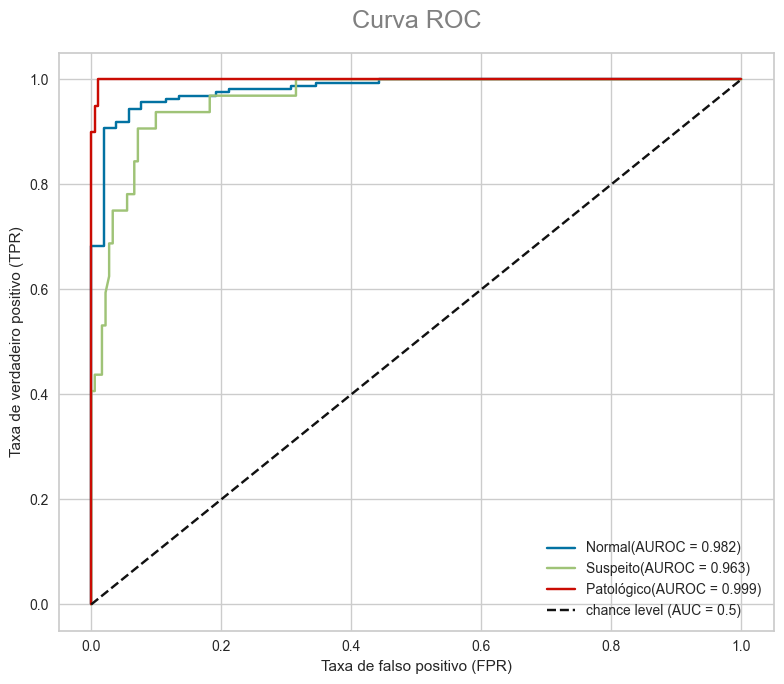

In [207]:
# instanciando os objetos Figure e Axes
fig, ax = plt.subplots(figsize=(8,7))

# laço sobre as classes do Dataset
for class_of_interest in label_binarizer.classes_:
    
    # pegando o indice da classe de interesse
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    
    # pegando os rótulos da classe de interesse
    Y_test = y_bin_val[:, class_id]
    
    # pegando a probabilidade da classe de interesse
    Y_probs = validation_y_probs[:, class_id]

    # claculando AUC
    auc = roc_auc_score(Y_test, Y_probs)

    # obtendo os valores de FPR e TPR
    fpr, tpr, _ = roc_curve(Y_test, Y_probs)
    
    # if ternário para a legenda
    label_str = "Normal" if class_of_interest == 0 else "Suspeito" if class_of_interest == 1 else "Patológico"
    
    # plot da curva no gráfico
    ax.plot(fpr, tpr, label=label_str + '(AUROC = %0.3f)' % auc)    
    # ax.fill_between(fpr, tpr, alpha=0.4)

ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set_title('Curva ROC', fontsize=18, pad=18, color="grey")
ax.set_xlabel('Taxa de falso positivo (FPR)')
ax.set_ylabel('Taxa de verdadeiro positivo (TPR)')
ax.legend() 

plt.tight_layout()

# Referências

* https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
